## 2) Implement a “grid search”

Investigate the follow parameters:

- activation units (sigmoid, relu, elu, etc.),

- different minimization algorithms (ADAM, RMSprop, Nesterov, etc.),

- different dropouts

- batch normalization

- different size or number of layers

In [1]:
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
import warnings

%load_ext autoreload
%autoreload 1
%aimport nn_model
%aimport create_data
%aimport preprocess

### 2.1) Create dataset

In [2]:
# number of data
N = 5000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x = create_data.sample_data(N, B)
y = create_data.assign_label(x)

mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

# re-scaling data 
x_scaled = preprocess.standardize(x, mean, std)

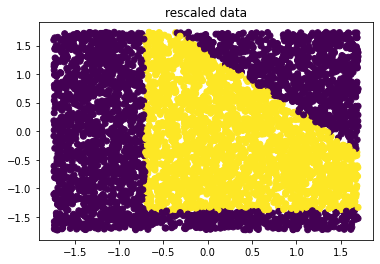

In [3]:
plt.scatter(x_scaled[:,0], x_scaled[:,1], c=y)
plt.title("rescaled data")
plt.show()

In [4]:
## SPLIT TRAIN AND VALID
train_frac = 0.7

N_train = int(N*train_frac)

training_data, training_labels = np.copy(x_scaled[0:N_train]), np.copy(y[0:N_train])
test_data,     test_labels     = np.copy(x_scaled[N_train:]),  np.copy(y[N_train:])

print(f"Traing set :\t{training_data.shape[0]}\nTest set  :\t{test_data.shape[0]}")

N_valid = 500

x_train, y_train = np.copy(training_data[N_valid:]),  np.copy(training_labels[N_valid:])
x_valid, y_valid = np.copy(training_data[0:N_valid]), np.copy(training_labels[0:N_valid])

print(f"\nN_train :\t{x_train.shape[0]} \nN_valid :\t{x_valid.shape[0]}")

Traing set :	3500
Test set  :	1500

N_train :	3000 
N_valid :	500


### 2.2) Define NN and its architecture

In [10]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(
    n_features,
    neurons           = [20, 20, 1],
    dropout_arc       = [1],
    dropout_rates     = [0.2],
    batch_norm_arc    = [2],
    hidden_activation = "relu",
    output_activation = "sigmoid",
    name              = "my lovely neural network",
    loss              = "binary_crossentropy",
    optimizer         = "adam",
    metrics           = ["accuracy"]
):
    # initialize architecture
    architecture = [n_features] + neurons
    input_dim    = n_features

    # create model
    network = nn_model.NN(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        nn_name           = name
    ) 

    # solves the "Model cannot be saved" issue
    network.compute_output_shape((None, input_dim))   
    
    network.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
    )
    return network

### 2.3) Modify the Hyperparameters to Optimize Performance of the Model

In [11]:
minibatch = 50
N_epochs  = 100

model_gridsearch = KerasClassifier(build_fn=create_model, 
                                   n_features=x.shape[1], 
                                   epochs=N_epochs, 
                                   batch_size=minibatch)

/tmp/ipykernel_21881/2038832178.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(build_fn=create_model,


#### 2.3.1) Grid Search

1)
- optimizer 
- (loss)
- hidden activation

2) architecture & dropout
- number of total neurons
- thin and long shape, fat and short shape, box shape
- dropout rates
- dropout layers

3) learning params
- epochs
- batch_size


In [12]:
class GridSearch():

    def __init__(
        self, 
        x_train,
        y_train,
        model_gridsearch,
        param_grid,
        n_jobs=-1,
        cv=4,
        verbose=0
        ):
        
        self.x_train  = x_train
        self.y_train = y_train
        self.model_gridsearch    = model_gridsearch
        self.param_grid = param_grid
        self.n_jobs = n_jobs
        self.cv = cv
        self.verbose = verbose
        
    def get_result(self):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid = GridSearchCV(estimator=self.model_gridsearch, param_grid=self.param_grid, n_jobs=self.n_jobs, cv=self.cv, verbose=self.verbose)
            self.grid_result = grid.fit(self.x_train,self.y_train, verbose=self.verbose)
        return self.grid_result

    def print_result(self):
        print("Best: %f using %s" % (self.grid_result.best_score_, self.grid_result.best_params_))
        means = self.grid_result.cv_results_['mean_test_score']
        stds = self.grid_result.cv_results_['std_test_score']
        params = np.array(self.grid_result.cv_results_['params'])

        idx   = np.argsort(means)[::-1]
        means = means[idx]
        stds  = stds[idx]
        params = params[idx]

        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))

##### 1

In [13]:
## OPTIMIZER
optimizer         = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Nadam', 'Adamax', 'Ftrl']
param_grid = dict(optimizer         = optimizer)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

15/15 [==============================] - 0s 1ms/step - loss: 0.0220 - accuracy: 0.9880


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1,
             param_grid={'optimizer': ['SGD', 'RMSprop', 'Adam', 'Adadelta',
                                       'Adagrad', 'Nadam', 'Adamax', 'Ftrl']})

In [14]:
grid.print_result()

Best: 0.992667 using {'optimizer': 'Adam'}
0.992667 (0.004472) with: {'optimizer': 'Adam'}
0.991667 (0.006420) with: {'optimizer': 'Adamax'}
0.990667 (0.003651) with: {'optimizer': 'RMSprop'}
0.990333 (0.004150) with: {'optimizer': 'Nadam'}
0.978333 (0.007265) with: {'optimizer': 'SGD'}
0.876667 (0.027415) with: {'optimizer': 'Adagrad'}
0.550333 (0.015184) with: {'optimizer': 'Ftrl'}
0.539667 (0.079383) with: {'optimizer': 'Adadelta'}


In [16]:
model_gridsearch = model_gridsearch.set_params(optimizer='Adam')

In [17]:
## HIDDEN ACTIVATION
hidden_activation = ['relu', 'elu', 'sigmoid', 'tanh', 'softmax', 'softsign', 'softplus', 'selu']
param_grid = dict(hidden_activation         = hidden_activation)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

2022-03-13 09:24:37.247499: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-13 09:24:37.354923: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-13 09:24:37.373448: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

15/15 [==============================] - 0s 1ms/step - loss: 0.1181 - accuracy: 0.9653


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1,
             param_grid={'hidden_activation': ['relu', 'elu', 'sigmoid', 'tanh',
                                               'softmax', 'softsign',
                                               'softplus', 'selu']})

In [18]:
grid.print_result()

Best: 0.987333 using {'hidden_activation': 'relu'}
0.987333 (0.002749) with: {'hidden_activation': 'relu'}
0.978333 (0.005110) with: {'hidden_activation': 'elu'}
0.978000 (0.009821) with: {'hidden_activation': 'tanh'}
0.974667 (0.003266) with: {'hidden_activation': 'softsign'}
0.972333 (0.008557) with: {'hidden_activation': 'selu'}
0.972000 (0.021685) with: {'hidden_activation': 'softmax'}
0.965000 (0.010765) with: {'hidden_activation': 'softplus'}
0.958333 (0.019491) with: {'hidden_activation': 'sigmoid'}


In [19]:
model_gridsearch = model_gridsearch.set_params(hidden_activation='relu')

In [20]:
## check default loss
loss = ['binary_crossentropy']
param_grid = dict(loss = loss)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

15/15 [==============================] - 0s 1ms/step - loss: 0.0190 - accuracy: 0.9920


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1, param_grid={'loss': ['binary_crossentropy']})

In [21]:
grid.print_result()

Best: 0.991000 using {'loss': 'binary_crossentropy'}
0.991000 (0.005764) with: {'loss': 'binary_crossentropy'}


In [22]:
## TRY hinge losses
loss = ['hinge', 'squared_hinge']
param_grid = dict(loss = loss)
y_train_hinge = y_train
y_train_hinge[y_train_hinge==0]=-1
grid = GridSearch(x_train, y_train_hinge, model_gridsearch, param_grid)
grid.get_result()

15/15 [==============================] - 0s 875us/step - loss: 0.5634 - accuracy: 0.9907


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1, param_grid={'loss': ['hinge', 'squared_hinge']})

In [23]:
grid.print_result()

Best: 0.989667 using {'loss': 'hinge'}
0.989667 (0.007623) with: {'loss': 'hinge'}
0.980667 (0.006000) with: {'loss': 'squared_hinge'}


In [24]:
## TOT GRIDSEARCH
optimizer         = ['RMSprop', 'Adamax', 'Nadam', 'Adam']
hidden_activation = ['relu', 'elu', 'tanh']

param_grid = dict(optimizer         = optimizer,
                  hidden_activation = hidden_activation)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

15/15 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.9760


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1,
             param_grid={'hidden_activation': ['relu', 'elu', 'tanh'],
                         'optimizer': ['RMSprop', 'Adamax', 'Nadam', 'Adam']})

In [26]:
grid.print_result()

Best: 0.991000 using {'hidden_activation': 'relu', 'optimizer': 'RMSprop'}
0.991000 (0.007506) with: {'hidden_activation': 'relu', 'optimizer': 'RMSprop'}
0.990000 (0.005121) with: {'hidden_activation': 'relu', 'optimizer': 'Nadam'}
0.989667 (0.003180) with: {'hidden_activation': 'relu', 'optimizer': 'Adam'}
0.988333 (0.008762) with: {'hidden_activation': 'relu', 'optimizer': 'Adamax'}
0.979667 (0.006557) with: {'hidden_activation': 'elu', 'optimizer': 'Adam'}
0.978000 (0.003055) with: {'hidden_activation': 'elu', 'optimizer': 'Nadam'}
0.977667 (0.006209) with: {'hidden_activation': 'elu', 'optimizer': 'RMSprop'}
0.975000 (0.005764) with: {'hidden_activation': 'tanh', 'optimizer': 'Adam'}
0.974667 (0.003887) with: {'hidden_activation': 'tanh', 'optimizer': 'RMSprop'}
0.966667 (0.010066) with: {'hidden_activation': 'tanh', 'optimizer': 'Nadam'}
0.949333 (0.014996) with: {'hidden_activation': 'elu', 'optimizer': 'Adamax'}
0.930333 (0.003317) with: {'hidden_activation': 'tanh', 'optimizer

In [27]:
model_gridsearch = model_gridsearch.set_params(hidden_activation='relu', optimizer='RMSprop')

#### 2

In [28]:
## DIFFERENT NN SHAPES
neurons        = [ [20,20,1], [4 for i in range(10)]+[1], [6 for i in range(6)]+[1]]

param_grid = dict(neurons        = neurons)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

15/15 [==============================] - 0s 1ms/step - loss: 0.0771 - accuracy: 0.9720


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1,
             param_grid={'neurons': [[20, 20, 1],
                                     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1],
                                     [6, 6, 6, 6, 6, 6, 1]]})

In [29]:
grid.print_result()

Best: 0.988000 using {'neurons': [20, 20, 1]}
0.988000 (0.008055) with: {'neurons': [20, 20, 1]}
0.973667 (0.010387) with: {'neurons': [6, 6, 6, 6, 6, 6, 1]}
0.773667 (0.211789) with: {'neurons': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]}


In [30]:
## DIFFERENT N of NEURONS
neurons        = [[5,5,1], [20,20,1], [100,100,1], [500,500,1]]
param_grid = dict(neurons        = neurons)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

15/15 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.9880


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1,
             param_grid={'neurons': [[5, 5, 1], [20, 20, 1], [100, 100, 1],
                                     [500, 500, 1]]})

In [31]:
grid.print_result()

Best: 0.991667 using {'neurons': [20, 20, 1]}
0.991667 (0.003697) with: {'neurons': [20, 20, 1]}
0.988000 (0.001886) with: {'neurons': [100, 100, 1]}
0.987333 (0.004372) with: {'neurons': [500, 500, 1]}
0.968000 (0.028535) with: {'neurons': [5, 5, 1]}


In [35]:
## DROPOUT PARAMS
dropout_rates        = [[i/10] for i in range(10)]
dropout_layers       = [[1], [2]]

param_grid = dict(dropout_rates        = dropout_rates,
                  dropout_arc          = dropout_layers)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

15/15 [==============================] - 0s 1ms/step - loss: 0.0468 - accuracy: 0.9960


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1,
             param_grid={'dropout_arc': [[1], [2]],
                         'dropout_rates': [[0.0], [0.1], [0.2], [0.3], [0.4],
                                           [0.5], [0.6], [0.7], [0.8], [0.9]]})

In [36]:
grid.print_result()

Best: 0.992333 using {'dropout_arc': [2], 'dropout_rates': [0.7]}
0.992333 (0.005686) with: {'dropout_arc': [2], 'dropout_rates': [0.7]}
0.992333 (0.003180) with: {'dropout_arc': [2], 'dropout_rates': [0.5]}
0.992000 (0.005497) with: {'dropout_arc': [1], 'dropout_rates': [0.0]}
0.991667 (0.005281) with: {'dropout_arc': [2], 'dropout_rates': [0.0]}
0.990667 (0.005249) with: {'dropout_arc': [2], 'dropout_rates': [0.6]}
0.990333 (0.004460) with: {'dropout_arc': [2], 'dropout_rates': [0.8]}
0.989667 (0.006420) with: {'dropout_arc': [1], 'dropout_rates': [0.2]}
0.989333 (0.003887) with: {'dropout_arc': [2], 'dropout_rates': [0.3]}
0.989000 (0.003317) with: {'dropout_arc': [1], 'dropout_rates': [0.1]}
0.989000 (0.004150) with: {'dropout_arc': [2], 'dropout_rates': [0.1]}
0.988667 (0.007333) with: {'dropout_arc': [1], 'dropout_rates': [0.3]}
0.988333 (0.006137) with: {'dropout_arc': [2], 'dropout_rates': [0.4]}
0.987667 (0.002560) with: {'dropout_arc': [2], 'dropout_rates': [0.2]}
0.986000 (0

In [39]:
## TOT GRID
neurons              = [[100, 100,1], [20,20,1]]
dropout_rates        = [[i/10] for i in range(10)]
dropout_layers       = [[1], [2]]

param_grid = dict(neurons        = neurons,
                  dropout_rates  = dropout_rates,
                  dropout_arc    = dropout_layers)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

15/15 [==============================] - 0s 1ms/step - loss: 0.0445 - accuracy: 0.9880


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1,
             param_grid={'dropout_arc': [[1], [2]],
                         'dropout_rates': [[0.0], [0.1], [0.2], [0.3], [0.4],
                                           [0.5], [0.6], [0.7], [0.8], [0.9]],
                         'neurons': [[100, 100, 1], [20, 20, 1]]})

In [40]:
grid.print_result()

Best: 0.992667 using {'dropout_arc': [2], 'dropout_rates': [0.6], 'neurons': [20, 20, 1]}
0.992667 (0.005773) with: {'dropout_arc': [2], 'dropout_rates': [0.6], 'neurons': [20, 20, 1]}
0.992333 (0.002560) with: {'dropout_arc': [2], 'dropout_rates': [0.2], 'neurons': [20, 20, 1]}
0.992333 (0.004150) with: {'dropout_arc': [1], 'dropout_rates': [0.1], 'neurons': [20, 20, 1]}
0.992000 (0.002981) with: {'dropout_arc': [2], 'dropout_rates': [0.4], 'neurons': [20, 20, 1]}
0.991333 (0.006566) with: {'dropout_arc': [2], 'dropout_rates': [0.5], 'neurons': [20, 20, 1]}
0.991333 (0.005121) with: {'dropout_arc': [2], 'dropout_rates': [0.0], 'neurons': [20, 20, 1]}
0.991333 (0.004055) with: {'dropout_arc': [2], 'dropout_rates': [0.1], 'neurons': [20, 20, 1]}
0.990333 (0.005364) with: {'dropout_arc': [2], 'dropout_rates': [0.9], 'neurons': [20, 20, 1]}
0.990000 (0.007630) with: {'dropout_arc': [1], 'dropout_rates': [0.0], 'neurons': [20, 20, 1]}
0.990000 (0.007454) with: {'dropout_arc': [2], 'dropout

In [42]:
model_gridsearch = model_gridsearch.set_params(dropout_arc=[2], dropout_rates=[0.6])

#### 3

In [43]:
## EPOCHS
N_epochs        = [10, 50, 100, 200, 300, 400]

param_grid = dict(epochs        = N_epochs)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

2022-03-13 10:02:13.786756: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-13 10:02:13.887488: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-13 10:02:13.933607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

15/15 [==============================] - 0s 1ms/step - loss: 0.0162 - accuracy: 0.9960


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1, param_grid={'epochs': [10, 50, 100, 200, 300, 400]})

In [44]:
grid.print_result()

Best: 0.990667 using {'epochs': 100}
0.990667 (0.008273) with: {'epochs': 100}
0.990000 (0.006000) with: {'epochs': 200}
0.989667 (0.008185) with: {'epochs': 400}
0.988000 (0.004522) with: {'epochs': 50}
0.987333 (0.007454) with: {'epochs': 300}
0.929667 (0.018794) with: {'epochs': 10}


In [34]:
## BATCH_SIZE
minibatch        = [N_train, 50, 100, 250, 500 , 1000]

param_grid = dict(batch_size        = minibatch)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

2022-03-13 08:50:43.165488: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-13 08:50:43.344395: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-13 08:50:43.373497: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

1/1 [==============================] - 0s 66ms/step - loss: 0.2272 - accuracy: 0.9093


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5c379164f0>,
             n_jobs=-1,
             param_grid={'batch_size': [3500, 50, 100, 250, 500, 1000]})

In [35]:
grid.print_result()

Best: 0.993000 using {'batch_size': 100}
0.993000 (0.004655) with: {'batch_size': 100}
0.990667 (0.007118) with: {'batch_size': 250}
0.986333 (0.007965) with: {'batch_size': 50}
0.965667 (0.006351) with: {'batch_size': 500}
0.908333 (0.013610) with: {'batch_size': 1000}
0.821333 (0.071037) with: {'batch_size': 3500}


In [45]:
N_epochs        = [200, 100]
minibatch        = [100, 250, 50]


param_grid = dict(epochs        = N_epochs,
                  batch_size     = minibatch)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

15/15 [==============================] - 0s 1ms/step - loss: 0.0211 - accuracy: 0.9947


GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce064ca040>,
             n_jobs=-1,
             param_grid={'batch_size': [100, 250, 50], 'epochs': [200, 100]})

In [46]:
grid.print_result()

Best: 0.992333 using {'batch_size': 50, 'epochs': 100}
0.992333 (0.003815) with: {'batch_size': 50, 'epochs': 100}
0.991000 (0.003317) with: {'batch_size': 250, 'epochs': 200}
0.990000 (0.008869) with: {'batch_size': 100, 'epochs': 100}
0.989333 (0.005416) with: {'batch_size': 100, 'epochs': 200}
0.988333 (0.005916) with: {'batch_size': 250, 'epochs': 100}
0.986000 (0.007087) with: {'batch_size': 50, 'epochs': 200}


In [48]:
model_gridsearch = model_gridsearch.set_params(epochs=100, batch_size=50)

### Predict grid with tuned hyperparameters

In [51]:
# check current model
model_gridsearch.get_params()

{'n_features': 2,
 'epochs': 100,
 'batch_size': 50,
 'optimizer': 'RMSprop',
 'hidden_activation': 'relu',
 'dropout_arc': [2],
 'dropout_rates': [0.6],
 'build_fn': <function __main__.create_model(n_features, neurons=[20, 20, 1], dropout_arc=[1], dropout_rates=[0.2], batch_norm_arc=[2], hidden_activation='relu', output_activation='sigmoid', name='my lovely neural network', loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])>}

In [59]:
fit = model_gridsearch.fit(x_train, y_train, validation_data=(x_valid, y_valid))

Epoch 1/100
60/60 [==============================] - 1s 4ms/step - loss: 0.6249 - accuracy: 0.6643 - val_loss: 0.5738 - val_accuracy: 0.7340
Epoch 2/100
60/60 [==============================] - 0s 2ms/step - loss: 0.4762 - accuracy: 0.7547 - val_loss: 0.4953 - val_accuracy: 0.8160
Epoch 3/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3712 - accuracy: 0.8353 - val_loss: 0.4040 - val_accuracy: 0.8880
Epoch 4/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3168 - accuracy: 0.8703 - val_loss: 0.3253 - val_accuracy: 0.8880
Epoch 5/100
60/60 [==============================] - 0s 2ms/step - loss: 0.2800 - accuracy: 0.8937 - val_loss: 0.2570 - val_accuracy: 0.9220
Epoch 6/100
60/60 [==============================] - 0s 2ms/step - loss: 0.2674 - accuracy: 0.9030 - val_loss: 0.2113 - val_accuracy: 0.9360
Epoch 7/100
60/60 [==============================] - 0s 2ms/step - loss: 0.2236 - accuracy: 0.9187 - val_loss: 0.1752 - val_accuracy: 0.9440
Epoch 8/100
6

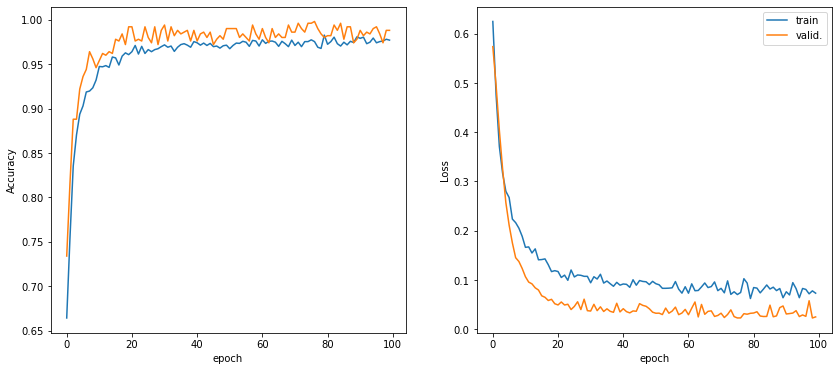

In [60]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train")
ax.plot(fit.history['val_accuracy'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax=AX[1]
ax.plot(fit.history['loss'],label="train")
ax.plot(fit.history['val_loss'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [61]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

51 2601
[50. 50.]


In [62]:
grid_r = grid/50

pred = model_gridsearch.predict(grid_r)

<function matplotlib.pyplot.show(close=None, block=None)>

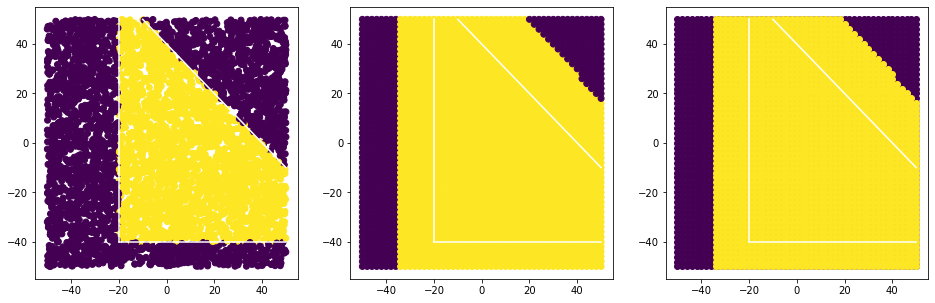

In [63]:
def boundaries():    
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
    
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
boundaries()
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
boundaries()
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()
plt.show
plt.show

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>